In [1]:
import os
import sys

import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import pandas as pd
sns.set(style='whitegrid', rc={
    'figure.figsize':(12,8),
    'legend.fontsize': 'large',
    'legend.title_fontsize': 'large',
    'axes.labelsize': 'large',
    'axes.titlesize':'large',
    'xtick.labelsize':'medium',
    'ytick.labelsize':'medium',
    'font.family': 'sans-serif',
    'font.sans-serif': 'Lucida Grande'
})

from simulated_utils import compare
from simulated_utils import SinglePeakCtsBanditEnv

In [2]:
def filter_df(df, **kwargs):
    for k,v in kwargs.items():
        df = df[df[k] == v]
    return df

In [3]:
env = SinglePeakCtsBanditEnv(noise_std=0.001)
data_beta = compare(env, 'beta', n_steps=30, repeats=10,
               lr=1e-1, batch_size=16*32, num_minibatches=16, ppo_epochs=10)

a = data_beta['pd_param_0_mean']
b = data_beta['pd_param_1_mean']
data_beta['mean'] = a / (a + b)
data_beta['std'] = (a * b / (a + b + 1)).apply(np.sqrt) / (a + b)
# Scale it to [-3,3]
data_beta['mean'] = data_beta['mean'] * 6 - 3
data_beta['std'] = data_beta['std'] * 6

/home/eecs/chloehsu/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
env = SinglePeakCtsBanditEnv(noise_std=0.001)
data_gaussian = compare(env, 'gaussian', n_steps=30, repeats=10,
               lr=1e-1, batch_size=16*32, num_minibatches=16, ppo_epochs=10)
data_gaussian['mean'] = data_gaussian['pd_param_0_mean']
data_gaussian['std'] = data_gaussian['pd_param_1_mean']

In [5]:
def plot_results(data_gaussian, data_beta, n_boot=1000):
    fig, axes = plt.subplots(2, 3, figsize=(10, 6.5), sharex=True)
    fig.subplots_adjust(left=-0.4)
    sns.lineplot(data=data_gaussian, x='iter', y='mean_reward', hue='method', ax=axes[0][0], n_boot=n_boot)
    axes[0][0].set_title('Mean Reward')
    axes[0][0].set_ylabel('Reward')
    sns.lineplot(data=data_gaussian, x='iter', y='mean', hue='method', ax=axes[0][1], n_boot=n_boot)
    axes[0][1].set_title('Action Distribution, Mean')
    axes[0][1].set_ylabel('Mean')
    axes[0][1].set_ylim([0, 3])
    sns.lineplot(data=data_gaussian, x='iter', y='std', hue='method', ax=axes[0][2], n_boot=n_boot)
    axes[0][2].set_title('Action Distribution, Stddev')
    axes[0][2].set_ylabel('Stddev')
    axes[0][2].set_ylim([0,1])
    
    
    sns.lineplot(data=data_beta, x='iter', y='mean_reward', hue='method', ax=axes[1][0], n_boot=n_boot)
    axes[1][0].set_ylabel('Mean Reward')
    sns.lineplot(data=data_beta, x='iter', y='mean', hue='method', ax=axes[1][1], n_boot=n_boot)
    axes[1][1].set_ylabel('Mean')
    #axes[1][1].set_ylim([0,1])
    sns.lineplot(data=data_beta, x='iter', y='std', hue='method', ax=axes[1][2], n_boot=n_boot)
    axes[1][2].set_ylabel('Stddev')
    #axes[1][2].set_ylim([0,1])

    handles, labels = axes.flatten()[0].get_legend_handles_labels()
    for ax in axes.flatten():
        ax.get_legend().remove()
        ax.set_xlabel('# Iterations')
    fig.legend(handles[1:], labels[1:], loc='upper center', ncol=4)
    
    pad = 5
    ax = axes[0][0]
    ax.annotate('Gaussian Policy', xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                        xycoords=ax.yaxis.label, textcoords='offset points', rotation=90,
                        size='large', ha='right', va='center')
    ax = axes[1][0]
    ax.annotate('Beta Policy', xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                        xycoords=ax.yaxis.label, textcoords='offset points',
                        size='large', ha='right', va='center', rotation=90)
    plt.show()

In [6]:
%matplotlib inline

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


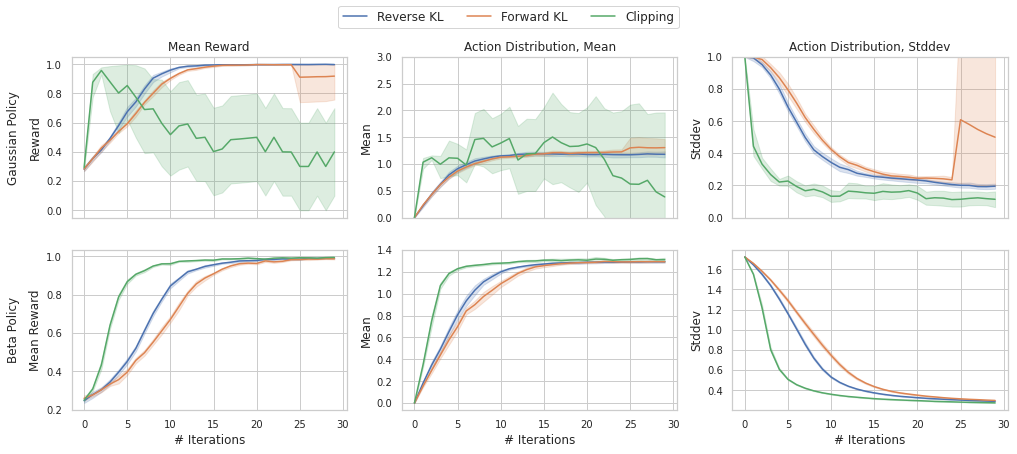

In [7]:
plot_results(data_gaussian[data_gaussian.method != 'Unregularized'],
             data_beta[data_beta.method != 'Unregularized'], n_boot=1000)